In [1]:
import numpy as np
import random
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_breast_cancer, load_wine
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

In [3]:
# Load datasets
data1 = load_breast_cancer()
X1 = data1.data  # Features
y1 = data1.target  # Target
feature_names1 = data1.feature_names  # Feature names for Breast Cancer
print(X1.shape, y1.shape)
print(feature_names1)

(569, 30) (569,)
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [8]:
class ACOFeatureSelection:
    def __init__(self, n_ants, n_iterations, evaporation_rate, alpha, beta, classifier, dataset, target, feature_names=None):
        self.n_ants = n_ants
        self.n_iterations = n_iterations
        self.evaporation_rate = evaporation_rate
        self.alpha = alpha  # Importance of pheromone
        self.beta = beta    # Importance of heuristic information
        self.classifier = classifier
        self.dataset = dataset
        self.target = target
        self.n_features = dataset.shape[1]
        self.pheromone = np.ones(self.n_features)  # Initial pheromone levels
        self.best_features = None
        self.best_score = 0
        self.performance_best = []  # Performance with best features at each iteration
        self.performance_all = []   # Performance with all features at each iteration
        self.feature_names = feature_names if feature_names is not None else [f"Feature {i}" for i in range(self.n_features)]

    def heuristic_info(self):
        """Heuristic information: Initially, treat all features equally."""
        return np.ones(self.n_features)

    def select_features(self, pheromone, heuristic):
        """Select features probabilistically based on pheromone and heuristic information."""
        probabilities = []
        for i in range(self.n_features):
            probabilities.append((pheromone[i] ** self.alpha) * (heuristic[i] ** self.beta))

        probabilities = np.array(probabilities) / np.sum(probabilities)  # Normalize probabilities

        # Roulette wheel selection: select features based on their probabilities
        selected_features = []
        for i in range(self.n_features):
            if random.random() < probabilities[i]:  # Probabilistically select feature
                selected_features.append(i)

        # Ensure at least one feature is selected
        if not selected_features:
            selected_features = [random.choice(range(self.n_features))]

        return selected_features

    def evaluate_features(self, selected_features):
        """Evaluate a subset of features using the classifier."""
        X_selected = self.dataset[:, selected_features]
        score = cross_val_score(self.classifier, X_selected, self.target, cv=5).mean()
        return score

    def evaluate_all_features(self):
        """Evaluate the performance using all features."""
        score = cross_val_score(self.classifier, self.dataset, self.target, cv=5).mean()
        return score

    def update_pheromones(self, ants_solutions):
        """Update pheromones based on the performance of ants."""
        # Evaporate pheromone
        self.pheromone *= (1 - self.evaporation_rate)

        # Update pheromone based on performance
        for features, score in ants_solutions:
            pheromone_increase = score / self.best_score if self.best_score > 0 else score
            for feature in features:
                self.pheromone[feature] += pheromone_increase  # Reward proportionally to score

    def optimize(self):
        """Main loop of the ACO algorithm."""
        heuristic = self.heuristic_info()

        for iteration in range(self.n_iterations):
            ants_solutions = []
            
            # Step 1: Evaluate the performance with all features
            score_all_features = self.evaluate_all_features()
            self.performance_all.append(score_all_features)
            
            for ant in range(self.n_ants):
                # Each ant selects features based on pheromone and heuristic info
                selected_features = self.select_features(self.pheromone, heuristic)
                score = self.evaluate_features(selected_features)
                ants_solutions.append((selected_features, score))

                # Track the best feature subset
                if score > self.best_score:
                    self.best_score = score
                    self.best_features = selected_features

            # Step 2: Update pheromones based on ants' solutions
            self.update_pheromones(ants_solutions)

            # Step 3: Record best performance (with the best subset of features)
            self.performance_best.append(self.best_score)
            if (iteration+1) == 1 or (iteration+1)%10 == 0:
                print(f"Iteration {iteration+1}/{self.n_iterations}, Best Score: {self.best_score:.4f}, All Features Score: {score_all_features:.4f}")

        return self.best_features, self.best_score

    def plot_performance(self):
        """Plot the performance over iterations."""
        plt.plot(self.performance_best, label='Best Feature Subset Performance')
        plt.plot(self.performance_all, label='All Features Performance', linestyle='--')
        plt.xlabel('Iteration')
        plt.ylabel('Accuracy')
        plt.title('ACO Feature Selection: Best Subset vs All Features')
        plt.legend()
        plt.show()

    def output_selected_and_not_selected_features(self):
        """Print the features that were selected and not selected."""
        selected_features = self.best_features
        not_selected_features = [i for i in range(self.n_features) if i not in selected_features]

        print("\nSelected Features:")
        for feature in selected_features:
            print(f"- {self.feature_names[feature]}")

        print("\nNot Selected Features:")
        for feature in not_selected_features:
            print(f"- {self.feature_names[feature]}")

In [13]:
# Parameters for the ACO algorithm
n_ants = 40
n_iterations =   20
evaporation_rate = 0.3
alpha = 1.0  # Importance of pheromone
beta = 1.0   # Importance of heuristic information

# Classifier: k-NN (can try others, like SVM or Decision Trees)
classifier = KNeighborsClassifier(n_neighbors=5)

Running ACO on Breast Cancer Dataset:
Iteration 1/20, Best Score: 0.9245, All Features Score: 0.9279
Iteration 10/20, Best Score: 0.9508, All Features Score: 0.9279
Iteration 20/20, Best Score: 0.9508, All Features Score: 0.9279


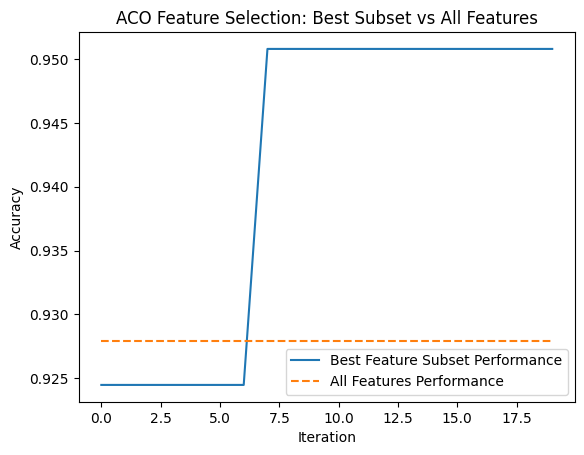

In [14]:
# Breast Cancer Dataset
print("Running ACO on Breast Cancer Dataset:")
aco1 = ACOFeatureSelection(n_ants=n_ants, n_iterations=n_iterations, evaporation_rate=evaporation_rate,
                          alpha=alpha, beta=beta, classifier=classifier, dataset=X1, target=y1, feature_names=feature_names1)
best_features1, best_score1 = aco1.optimize()
aco1.plot_performance()

In [12]:
aco1.output_selected_and_not_selected_features()
print(f"Best classification score for Breast Cancer: {best_score1:.4f}")


Selected Features:
- mean radius
- worst perimeter

Not Selected Features:
- mean texture
- mean perimeter
- mean area
- mean smoothness
- mean compactness
- mean concavity
- mean concave points
- mean symmetry
- mean fractal dimension
- radius error
- texture error
- perimeter error
- area error
- smoothness error
- compactness error
- concavity error
- concave points error
- symmetry error
- fractal dimension error
- worst radius
- worst texture
- worst area
- worst smoothness
- worst compactness
- worst concavity
- worst concave points
- worst symmetry
- worst fractal dimension
Best classification score for Breast Cancer: 0.9385
